# 1. Installs / Imports

In [2]:
#installs
! pip install -q keras
! pip install cv2

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#imports
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
from tqdm import tqdm
import pickle
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt
from scipy.spatial.distance import cdist

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from tensorflow.keras.callbacks import *
from keras import backend as K
import keras
import tensorflow as tf

import sys


from sklearn import metrics

# 2. Creating the Configuration

In [4]:
random.seed(1234)
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 28 # the number of joints 14x2
        self.joint_d = 3 # the dimension of joints
        self.feat_d = 378 
        self.filters = 256
        self.classes = 7 #the number of coarse classes (renamed from clc_coarse) now self.classes
C = Config()

# 3. Network Definitions + functions

In [5]:
#returns a pose difference by subtracting 2 frames in x
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W])
    return x

#looks at slow global motion and fast global motion 
# Mslow = S(k+1) - S(k)
# mFast =  S(k+2) − S(k)

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast


#Applies a 1D convolution (cnn layer)
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

#applies c1D twice to create 2x 1D convolution (2x CNN(x,filters))
def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x

#Densely-connected NN layer 1D.
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=128,joint_n=28,joint_d=2,feat_d=378,filters=16):
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))

    diff_slow,diff_fast = pose_motion(P,frame_l)

    #JCD_Track
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    #defide by 2 for fast track
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    #CNN_slow_track
    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    #defide by 2 for fast track
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    #CNN_Fast_track
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)

    #concat 3 and maxpool layers to 2x CNN(3,2*filters)/2 
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    #maxpool layers to 2x CNN(3,4*filters)/2
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    # maxpool layers to 2x CNN(3,8*filters)/2
    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)

    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(frame_l=128,joint_n=28,joint_d=3,feat_d=378,clc_num=7,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))
    P = Input(name='P', shape=(frame_l,joint_n,joint_d))

    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)

    x = FM([M,P])
    #Global Average Pooling over x
    x = GlobalMaxPool1D()(x)

    #Dense Layers 1D (FC128) 2x HIER OPLOSSEN MISCHIEN??? 128 * 4
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)

    #Dense over class numbers
    x = Dense(clc_num, activation='softmax')(x)

    #Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.classes,C.filters)
DD_Net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 M (InputLayer)              [(None, 32, 378)]            0         []                            
                                                                                                  
 P (InputLayer)              [(None, 32, 28, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 4, 2048)              2725580   ['M[0][0]',                   
                                                          8          'P[0][0]']                   
                                                                                                  
 global_max_pooling1d (Glob  (None, 2048)                 0         ['model[0][0]']         

# 4. Data processing funcs

In [7]:
#Rescale with zoom factor (target_l/l_shape) so zoom to target_l.
def zoom(p,target_l=32,joints_num=28,joints_dim=3):
    l = p.shape[0]
    p_new = np.empty([target_l,joints_num,joints_dim])
    for m in range(joints_num):
        for n in range(joints_dim): 
            p[:,m,n] = medfilt(p[:,m,n],3)
            p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
    return p_new

#normalizes the range to middle of hand.
def normlize_range(p):
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
    return p

#removes duplicates and keeps order of list. (same as set function in python but keeps order)
def list_set(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

#JCD matrix
def get_CG(p,C):
    M = []
    #Gives the indices for upter triangle with offset of 1 returning only the upper non 0 
    iu = np.triu_indices(C.joint_n,1,C.joint_n)
    for f in range(C.frame_l):
        #distance matrix
        d_m = cdist(p[f],np.concatenate([p[f],np.zeros([1,C.joint_d])]),'euclidean')
        d_m = d_m[iu]
        M.append(d_m)
    M = np.stack(M)
    return M

# 5. Evaluation Function Confusion Matrix

In [8]:
def Confusion_Matrix (y_true, y_pred, labels):
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_perc, display_labels=labels)
    disp.plot()
    plt.show()
    

# 6. Load the data

In [9]:
#fold file locations
file_list_train = glob.glob("./data/Fold-Data/Fold1/Train-set/*/*.txt")
file_list_test = glob.glob("./data/Fold-Data/Fold1/Test-set/*/*.txt")

#Load train and test from folder

Train = []
Test = []

#load train
for file_path in file_list_train:
    with open(file_path) as f_input:
        values = []
        for line in f_input:
            split = line.split(";")
            del split[0]
            del split[-1]
            values.append(split)
        Train.append(values)

#load test
for file_path in file_list_test:
    with open(file_path) as f_input:
        values = []
        for line in f_input:
            split = line.split(";")
            del split[0]
            del split[-1]
            values.append(split)
        Test.append(values)

#Create labels from foldername by using os functions for Train.
label_names= []
for i in range (len(file_list_train)):
    label_names.append(os.path.basename(os.path.dirname(file_list_train[i])))

#Create labels from foldername by using os functions for Test.
label_names_test = []
for i in range (len(file_list_test)):
    label_names_test.append(os.path.basename(os.path.dirname(file_list_test[i])))

#create orderd list of label_names.
label_list = list_set(label_names)

# 7. Data processing steps

In [10]:
#run data_processing on train data
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train))): 
    #reshape to desired format
    p = np.copy(Train[i]).reshape([-1,28,3])
    #retype it to np.flaot
    p = np.asarray(p, dtype=float)
    #do zoom (frames = 64 in console) and Normalize to middle of hand.
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.classes)
    label[label_list.index(label_names[i])] = 1  

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)
X_1 = np.stack(X_1)
Y = np.stack(Y)

  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\benni\AppData\Local\Temp\ipykernel_13936\3215800240.py:8: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
100%|██████████| 47/47 [00:03<00:00, 12.54it/s]


In [11]:
#run data_processing on test data
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test))): 
    #reshape to desired format
    p = np.copy(Test[i]).reshape([-1,28,3])
    #retype it to np.flaot
    p = np.asarray(p, dtype=float)
    #do zoom and Normalize to middle of hand.
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.classes)
    label[label_list.index(label_names_test[i])] = 1  

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0)
X_test_1 = np.stack(X_test_1)
Y_test = np.stack(Y_test)

  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\benni\AppData\Local\Temp\ipykernel_13936\3215800240.py:8: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
100%|██████████| 15/15 [00:00<00:00, 20.16it/s]


# 8. Train the Network

In [31]:
# it may takes several times to reach the reported performance 
lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=800,
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)
            )


Epoch 1/800
1/1 [==============================] - 19s 19s/step - loss: 2.3035 - accuracy: 0.1702 - val_loss: 2.1699 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 2/800
1/1 [==============================] - 15s 15s/step - loss: 2.2334 - accuracy: 0.2128 - val_loss: 2.0639 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 3/800
1/1 [==============================] - 13s 13s/step - loss: 1.9161 - accuracy: 0.2553 - val_loss: 2.0000 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 4/800
1/1 [==============================] - 12s 12s/step - loss: 1.9476 - accuracy: 0.2553 - val_loss: 2.0971 - val_accuracy: 0.1333 - lr: 1.0000e-04
Epoch 5/800
1/1 [==============================] - 12s 12s/step - loss: 1.7151 - accuracy: 0.3830 - val_loss: 2.3869 - val_accuracy: 0.1333 - lr: 1.0000e-04
Epoch 6/800
1/1 [==============================] - 13s 13s/step - loss: 1.6964 - accuracy: 0.4043 - val_loss: 2.7069 - val_accuracy: 0.1333 - lr: 1.0000e-04
Epoch 7/800
1/1 [==============================] - 13s 13s

In [15]:
lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=200,
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)
            )

Epoch 1/500
1/1 [==============================] - 6s 6s/step - loss: 0.5531 - accuracy: 0.8600 - val_loss: 0.8086 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 2/500
1/1 [==============================] - 0s 363ms/step - loss: 0.5806 - accuracy: 0.8800 - val_loss: 0.8122 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 3/500
1/1 [==============================] - 0s 415ms/step - loss: 0.5132 - accuracy: 0.8800 - val_loss: 0.8187 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 4/500
1/1 [==============================] - 0s 395ms/step - loss: 0.5054 - accuracy: 0.8400 - val_loss: 0.8269 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 5/500
1/1 [==============================] - 0s 384ms/step - loss: 0.5023 - accuracy: 0.9200 - val_loss: 0.8345 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 6/500
1/1 [==============================] - 0s 379ms/step - loss: 0.6860 - accuracy: 0.8200 - val_loss: 0.8456 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 7/500
1/1 [==============================] - 0s 3

# 9. Plot Network

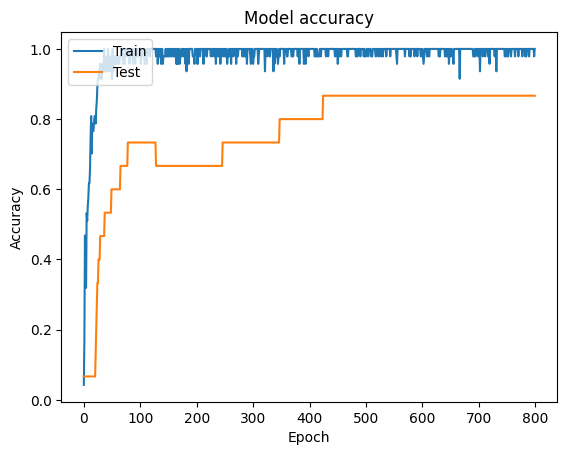

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 424ms/step


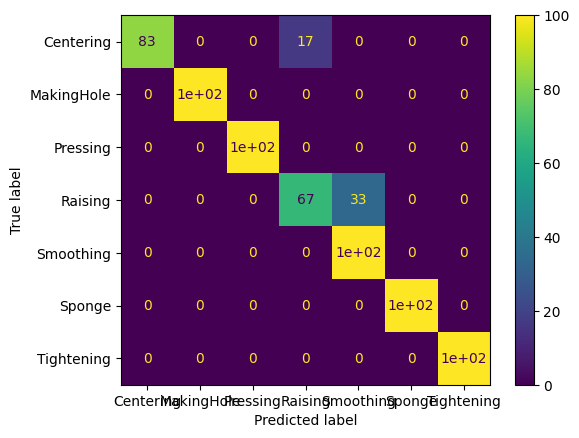

In [13]:
# Plot Confusion matrix
Y_pred = DD_Net.predict([X_test_0,X_test_1])

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(label_list[i])

y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(label_list[i])

Confusion_Matrix(y_true, y_pred, label_list)

In [ ]:
#Print the prediction to a result file.
Y_pred = DD_Net.predict([X_test_0,X_test_1])
with open("result.txt", "w") as f:
    for i in range(len(y_pred)):
        print(y_pred[i], file=f)

# 10. Save the Model

In [16]:
# save the model to disk
filename = 'Train_Model_FOLD1_512FI_256Fr.sav'
pickle.dump(DD_Net, open(filename, 'wb'))

# 11. Load pre-trained model + prediction steps

In [12]:
# load the model from disk
filename = 'Train_Model_FOLD1_256FI_32Fr.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [13]:
# recreate new config for new model parameters loaded model
random.seed(1234)
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 28 # the number of joints 14x2
        self.joint_d = 3 # the dimension of joints
        self.feat_d = 378 
        self.filters = 256 #number of filters in network (per block)
        self.classes = 7 #the number of classes in the data
C = Config()

#run data_processing on test data again for testing input
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test))): 
    #reshape to desired format
    p = np.copy(Test[i]).reshape([-1,28,3])
    #retype it to np.flaot
    p = np.asarray(p, dtype=float)
    #do zoom and Normalize to middle of hand.
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.classes)
    label[label_list.index(label_names_test[i])] = 1  

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0)
X_test_1 = np.stack(X_test_1)
Y_test = np.stack(Y_test)

  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\benni\AppData\Local\Temp\ipykernel_13936\3215800240.py:8: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
100%|██████████| 15/15 [00:00<00:00, 20.77it/s]


1/1 [==============================] - 1s 625ms/step


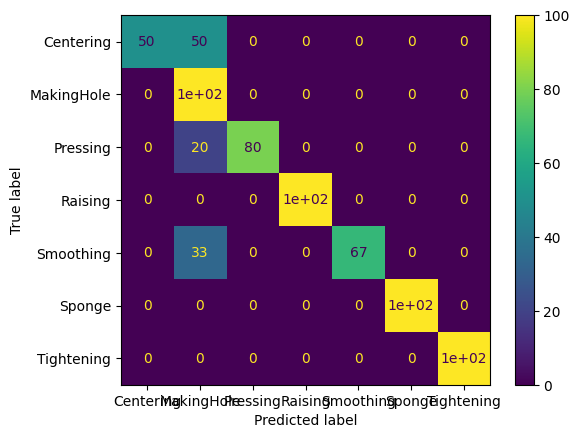

In [14]:
# Plot Confusion matrix
Y_pred = loaded_model.predict([X_test_0,X_test_1])

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(label_list[i])

y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(label_list[i])

Confusion_Matrix(y_true, y_pred, label_list)

In [29]:
#Print the prediction to a result file.
Y_pred = loaded_model.predict([X_test_0,X_test_1])
with open("result.txt", "w") as f:
    for i in range(len(y_pred)):
        print(y_pred[i], file=f)

1/1 [==============================] - 0s 394ms/step
